In [ ]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, ".."))

from scripts.logger import LoggerManager
from CICIDS2017.preprocessing.dataset import CICIDS2017

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
lm = LoggerManager(log_dir=f"{current_dir}/logs", log_name="test_dl_models")
lm.logger.info("Logger initialized")

dataset = CICIDS2017(logger=lm.logger).encode(attack_encoder="onehot").scale(scaler="minmax").optimize_memory()

2025-11-15 18:49:48,964 - INFO - Logger initialized
2025-11-15 18:49:48,965 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-15 18:49:49,499 - INFO - Loading data
2025-11-15 18:50:03,019 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-15 18:50:17,567 - INFO - ============================================================
2025-11-15 18:50:17,568 - INFO - Preprocessing completed successfully
2025-11-15 18:50:17,569 - INFO - Final dimensions: 1,942,693 rows x 71 columns
2025-11-15 18:50:17,569 - INFO - Total rows removed: 271,776 (12.27%)
2025-11-15 18:50:17,570 - INFO - data retention rate: 87.73%
2025-11-15 18:50:17,571 - INFO - ============================================================
2025-11-15 18:50:17,572 - INFO - Encoding attack labels...
2025-11-15 18:50:18,677 - INFO - Attack labels encoded using OneHotEncoder(sparse_output=False) encoder.
2025-11-15 18:50:18,677 - INFO - Scaling dataset features...
2025-11-15 18:50:42,5

In [3]:
bce_loss = nn.BCELoss()
ce_loss = nn.CrossEntropyLoss()

def train_nids_model(model, optimizer, scheduler, train_loader, val_loader, device, epochs=25):
    epoch_losses = []
    epoch_val_losses = []
    # Training loop
    tqdm_epochs = tqdm(range(int(epochs)), desc="Training Progress")
    for epoch in tqdm_epochs:
        model.train()
        losses = []
        for X_train, y1_train, y2_train in train_loader:
            # Forward pass
            out1, out2 = model(X_train)
            loss1 = bce_loss(out1, y1_train)
            loss2 = ce_loss(out2, y2_train)
            loss = loss1 + loss2
            losses.append(loss)

        epoch_loss = sum(losses) / len(losses)
        epoch_losses.append(epoch_loss.cpu().detach().numpy())
            
        # Backward pass and optimization
        optimizer.zero_grad()
        epoch_loss.backward()
        optimizer.step()

        scheduler.step(epoch_loss.detach())
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_losses = []
            for X_val, y1_val, y2_val in val_loader:
                val_out1, val_out2 = model(X_val)
                val_loss = bce_loss(val_out1, y1_val) + ce_loss(val_out2, y2_val)
                val_losses.append(val_loss)

            epoch_val_loss = sum(val_losses) / len(val_losses)
            epoch_val_losses.append(epoch_val_loss.cpu().detach().numpy())
            
        tqdm_epochs.set_description(f"Loss: {epoch_loss.item():.4f}, Val Loss: {epoch_val_loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.2e}")

    return model, epoch_losses, epoch_val_losses


In [4]:
def display_loss(list_epoch_loss, list_val_loss, title, dir, logger, epoch_min=2):
    lm.logger.info("Plotting loss curve...")
    # Plotting loss curve with linear and log scale
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(list_epoch_loss[epoch_min:], label='Training Loss')
    plt.plot(list_val_loss[epoch_min:], '-r', label='Validation Loss')
    plt.title(f"Loss Curve - {title}")  
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(list_epoch_loss[epoch_min:], label='Training Loss')
    plt.plot(list_val_loss[epoch_min:], '-r', label='Validation Loss') 
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    loss_plot_path = f"{dir}/loss_img/{title}_loss.png"
    os.makedirs(f"{dir}/loss_img", exist_ok=True)
    plt.savefig(loss_plot_path, bbox_inches='tight', dpi=300)
    lm.logger.info(f"Loss curve saved as {loss_plot_path}")
    plt.show()

In [5]:
X = torch.FloatTensor(dataset.scaled_features).to(device)
y1 = torch.FloatTensor(dataset.is_attack).to(device)
y2 = torch.FloatTensor(dataset.attack_classes).to(device)

dataset_size = len(X)

# Randomly get a subset of the data
subset_size = min(50000, dataset_size)
indices = torch.randperm(dataset_size)[:subset_size]
X = X[indices]
y1 = y1[indices]
y2 = y2[indices]


In [6]:
# Display num of elements per class
unique, counts = torch.unique(torch.argmax(y1, dim=1), return_counts=True)
class_distribution = dict(zip(unique.cpu().numpy(), counts.cpu().numpy()))
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

difference = subset_size - sum(counts).item()
print(f"Class 'benign' (0): {difference} samples")

Class 0: 39326 samples
Class 1: 10674 samples
Class 'benign' (0): 0 samples


In [7]:
# Display num of elements per class
unique, counts = torch.unique(torch.argmax(y2, dim=1), return_counts=True)
class_distribution = dict(zip(unique.cpu().numpy(), counts.cpu().numpy()))
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

Class 0: 39326 samples
Class 1: 50 samples
Class 2: 3328 samples
Class 3: 4971 samples
Class 4: 1 samples
Class 6: 2324 samples


In [8]:
dataset_tensor = TensorDataset(X, y1, y2)

train_size = int(0.8 * len(dataset_tensor))
val_size = len(dataset_tensor) - train_size

print(f"Dataset size: {len(dataset_tensor)}, Train size: {train_size}, Val size: {val_size}")

Dataset size: 50000, Train size: 40000, Val size: 10000


In [9]:
train_dataset, val_dataset = random_split(dataset_tensor, [train_size, val_size])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [11]:
input_size = dataset.scaled_features.shape[1]
num_classes = len(dataset.attack_classes[0])
print(f"Input size: {input_size}, Num classes: {num_classes}")

Input size: 70, Num classes: 7


In [12]:
class NetworkIntrusionMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NetworkIntrusionMLP, self).__init__()

        self.features = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.RReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Tanh(),
        )

        self.classifier1 = nn.Sequential(
            nn.Linear(64, 16),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(16, num_classes[0]),
        )

        self.classifier2 = nn.Sequential(
            nn.Linear(64 + num_classes[0], 64),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(64, num_classes[1]),
        )

    def forward(self, x):
        features = self.features(x)
        out1 = self.classifier1(features)
        # Combine features and out1 for second classifier
        x2 = torch.cat((features, out1), dim=1)
        out2 = self.classifier2(x2)
        return torch.softmax(out1, dim=1), torch.softmax(out2, dim=1)

In [13]:
model_mlp = NetworkIntrusionMLP(input_size=input_size, num_classes=[2, num_classes]).to(device)
num_parameters = sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)
print(f"Number of trainable parameters in MLP model: {num_parameters}")

learning_rate_mlp = 1e-2
num_epochs_mlp = 1000

optimizer_mlp = optim.AdamW(model_mlp.parameters(), lr=learning_rate_mlp)
scheduler_mlp = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mlp, mode='min', factor=0.8, patience=8, min_lr=1e-6)

Number of trainable parameters in MLP model: 27833


In [14]:
model_mlp, train_losses_mlp, val_losses_mlp = train_nids_model(
    model=model_mlp,
    optimizer=optimizer_mlp,
    scheduler=scheduler_mlp,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_mlp
)

Loss: 1.2954, Val Loss: 1.3069, LR: 1.00e-06: 100%|██████████| 1000/1000 [23:09<00:00,  1.39s/it]


2025-11-15 19:13:54,646 - INFO - Plotting loss curve...
2025-11-15 19:13:55,406 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/CICIDS2017/loss_img/MLP_NIDS_loss.png


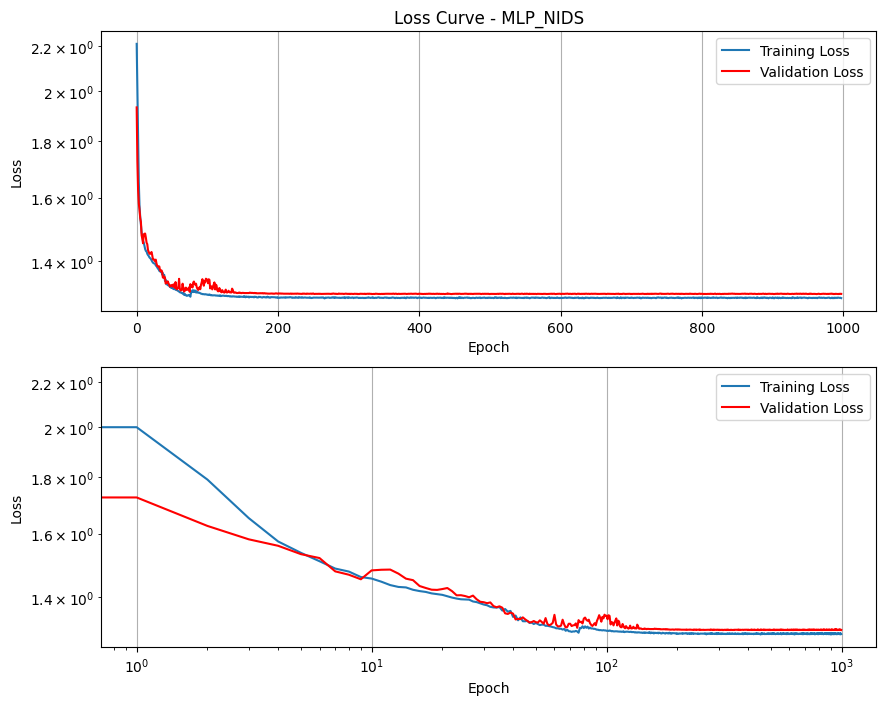

In [15]:
display_loss(
    list_epoch_loss=train_losses_mlp,
    list_val_loss=val_losses_mlp,
    title="MLP_NIDS",
    dir=current_dir,
    logger=lm.logger,
    epoch_min=2
)

/home/alexin/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alexin/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/alexin/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and be

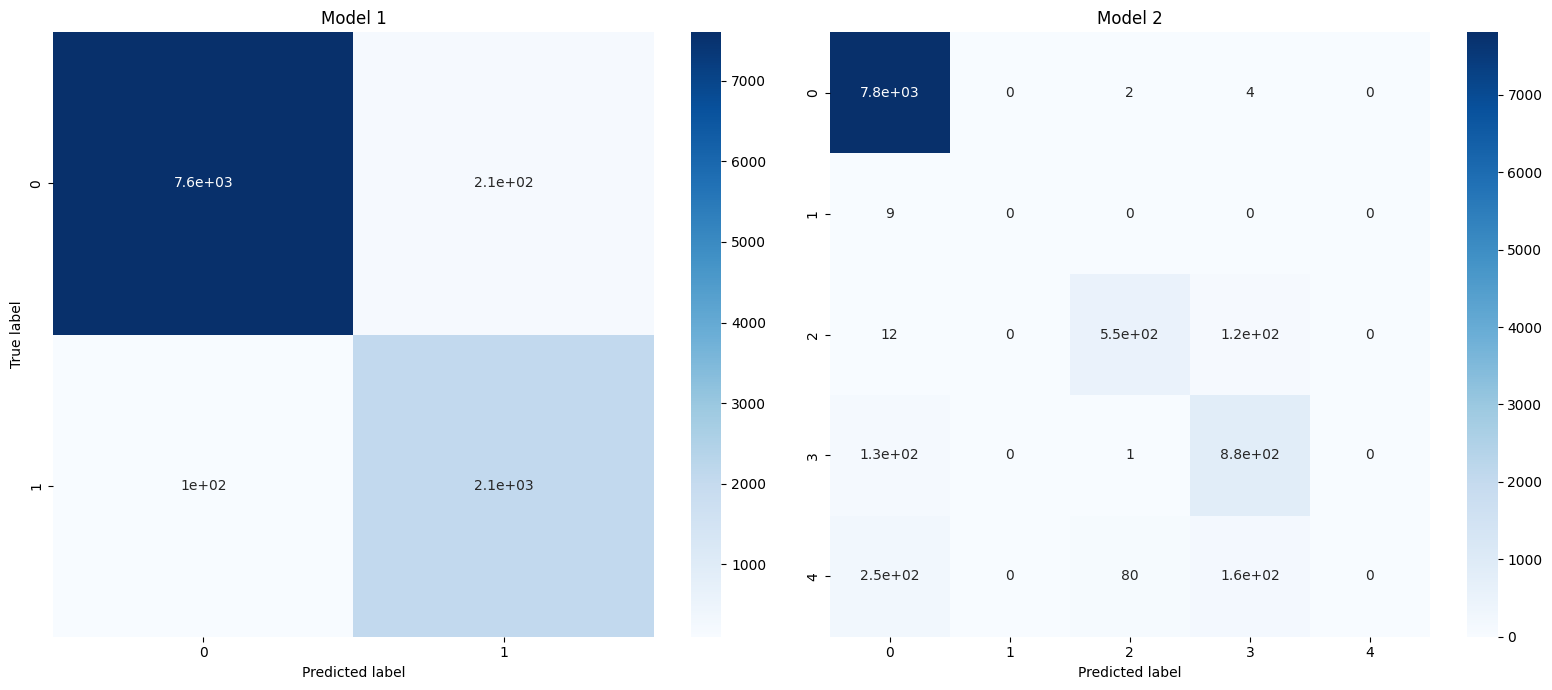

2025-11-15 19:21:48,269 - INFO - Classification Report - Attack Detection:
              precision    recall  f1-score   support

           0     0.9870    0.9730    0.9800      7813
           1     0.9082    0.9543    0.9307      2187

    accuracy                         0.9689     10000
   macro avg     0.9476    0.9636    0.9553     10000
weighted avg     0.9698    0.9689    0.9692     10000

2025-11-15 19:21:48,270 - INFO - Classification Report - Attack Classification:
              precision    recall  f1-score   support

           0     0.9514    0.9992    0.9747      7813
           1     0.0000    0.0000    0.0000         9
           2     0.8685    0.8119    0.8392       675
           3     0.7592    0.8734    0.8123      1011
           6     0.0000    0.0000    0.0000       492

    accuracy                         0.9238     10000
   macro avg     0.5158    0.5369    0.5252     10000
weighted avg     0.8787    0.9238    0.9003     10000



In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model_mlp.eval()
all_preds1 = []
all_labels1 = []
all_preds2 = []
all_labels2 = []
with torch.no_grad():
    for X_val, y1_val, y2_val in val_loader:
        out1, out2 = model_mlp(X_val)
        preds1 = torch.argmax(out1, dim=1).cpu().numpy()
        labels1 = torch.argmax(y1_val, dim=1).cpu().numpy()
        preds2 = torch.argmax(out2, dim=1).cpu().numpy()
        labels2 = torch.argmax(y2_val, dim=1).cpu().numpy()

        all_preds1.extend(preds1)
        all_labels1.extend(labels1)
        all_preds2.extend(preds2)
        all_labels2.extend(labels2)

classification_report1 = classification_report(all_labels1, all_preds1, digits=4)
confusion_matrix1 = confusion_matrix(all_labels1, all_preds1)
classification_report2 = classification_report(all_labels2, all_preds2, digits=4)
confusion_matrix2 = confusion_matrix(all_labels2, all_preds2)

fig, axs = plt.subplots(1, 2, figsize = (16, 7))

sns.heatmap(confusion_matrix1, annot = True, cmap = 'Blues', ax = axs[0])
axs[0].set_title('Model 1')

sns.heatmap(confusion_matrix2, annot = True, cmap = 'Blues', ax = axs[1])
axs[1].set_title('Model 2')

axs[0].set_xlabel('Predicted label')
axs[0].set_ylabel('True label')
axs[1].set_xlabel('Predicted label')

fig.tight_layout()
plt.show()

lm.logger.info("Classification Report - Attack Detection:\n" + classification_report1)
lm.logger.info("Classification Report - Attack Classification:\n" + classification_report2)

In [33]:
class NetworkIntrustionCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(NetworkIntrustionCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.classifier1 = nn.Sequential(
            nn.Linear(64 * (input_size // 4), 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes[0])
        )

        self.classifier2 = nn.Sequential(
            nn.Linear(64 * (input_size // 4) + num_classes[0], 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes[1])
        )
    
    def forward(self, x):
        # Reshape input for 1D convolution
        x = x.unsqueeze(1)  # Add channel dimension
        features = self.features(x)
        features = features.view(features.size(0), -1)
        out1 = self.classifier1(features)
        x2 = torch.cat((features, out1), dim=1)
        out2 = self.classifier2(x2)
        return torch.softmax(out1, dim=1), torch.softmax(out2, dim=1)

In [34]:
model_cnn = NetworkIntrustionCNN(input_channels=1, num_classes=[2, num_classes]).to(device)
num_parameters_cnn = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f"Number of trainable parameters in CNN model: {num_parameters_cnn}")

learning_rate_cnn = 1e-1
num_epochs_cnn = 50

optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=learning_rate_cnn)
scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='min', factor=0.8, patience=5, min_lr=1e-6)

Number of trainable parameters in CNN model: 111721


In [35]:
model_cnn, train_loss_cnn, val_loss_cnn = train_nids_model(
    model=model_cnn,
    optimizer=optimizer_cnn,
    scheduler=scheduler_cnn,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_cnn
)

Loss: 22.5950, Val Loss: 23.1486, LR: 1.68e-02: 100%|██████████| 50/50 [01:18<00:00,  1.56s/it]


2025-11-15 19:27:56,146 - INFO - Plotting loss curve...
2025-11-15 19:27:56,750 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/CICIDS2017/loss_img/NetworkIntrustionCNN_loss.png


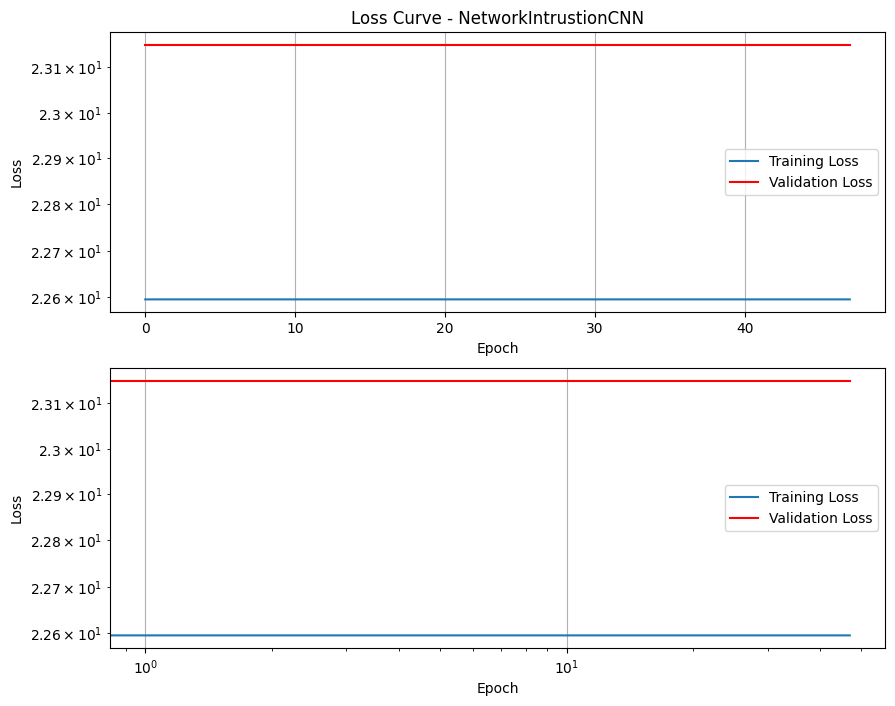

In [36]:
display_loss(
    train_loss_cnn,
    val_loss_cnn,
    title="NetworkIntrustionCNN",
    dir=current_dir,
    logger=lm.logger,
    epoch_min=2
)

In [37]:
class NetworkIntrusionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(NetworkIntrusionLSTM, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True
        )
        
        self.classifier1 = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes[0])
        )

        self.classifier2 = nn.Sequential(
            nn.Linear(hidden_size + num_classes[0], 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes[1])
        )
    
    def forward(self, x):
        # LSTM expects (batch, seq_len, features)
        lstm_out, _ = self.lstm(x)
        # Use the last time step
        out1 = self.classifier1(lstm_out)
        in2 = torch.cat((lstm_out, out1), dim=1)
        out2 = self.classifier2(in2)
        return torch.softmax(out1, dim=1), torch.softmax(out2, dim=1)

In [41]:
model_lstm = NetworkIntrusionLSTM(input_size=input_size, hidden_size=128, num_layers=3, num_classes=[2, num_classes]).to(device)

learning_rate_lstm = 1e-2
num_epochs_lstm = 50

optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate_lstm)
scheduler_lstm = optim.lr_scheduler.ReduceLROnPlateau(optimizer_lstm, mode='min', factor=0.8, patience=5, min_lr=1e-6)

In [42]:
model_lstm, train_loss_lstm, val_loss_lstm = train_nids_model(
    model=model_lstm,
    optimizer=optimizer_lstm,
    scheduler=scheduler_lstm,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_lstm
)

Loss: 1.8980, Val Loss: 1.9069, LR: 4.10e-03: 100%|██████████| 50/50 [01:39<00:00,  1.98s/it]


2025-11-15 19:37:23,303 - INFO - Plotting loss curve...
2025-11-15 19:37:23,932 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/CICIDS2017/loss_img/LSTM_NIDS_Model_loss.png


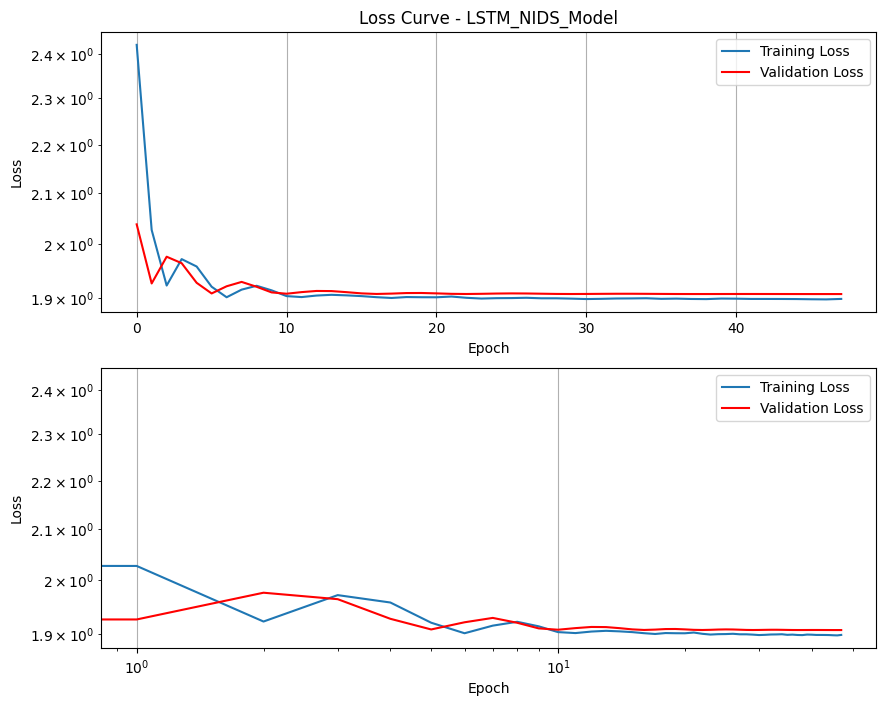

In [43]:
display_loss(
    train_loss_lstm, 
    val_loss_lstm, 
    title="LSTM_NIDS_Model", 
    dir=current_dir, 
    logger=lm.logger,
    epoch_min=2
)